In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Metrics.

def accuracy(y_true, probas_pred):
    y_pred = np.argmax(probas_pred, axis=1)
    return accuracy_score(y_true, y_pred)

def weighted_average_precision(y_true, probas_pred):
    classes, counts = np.unique(y_true, return_counts=True)
    scores = np.zeros(len(classes))
    for i, class_ in enumerate(classes):
        y_true_ = (y_true == class_).astype(int)
        probas_pred_ = probas_pred[:, class_]
        scores[i] = average_precision_score(y_true_, probas_pred_)
    return np.sum(scores * counts) / np.sum(counts)

def macro_average_precision(y_true, probas_pred):
    classes = np.unique(y_true)
    scores = np.zeros(len(classes))
    for i, class_ in enumerate(classes):
        y_true_ = (y_true == class_).astype(int)
        probas_pred_ = probas_pred[:, class_]
        scores[i] = average_precision_score(y_true_, probas_pred_)
    return np.mean(scores)

def macro_f1(y_true, probas_pred):
    y_pred = np.argmax(probas_pred, axis=1)
    return f1_score(y_true, y_pred, average="macro", zero_division=0)

def weighted_f1(y_true, probas_pred):
    y_pred = np.argmax(probas_pred, axis=1)
    return f1_score(y_true, y_pred, average="macro", zero_division=0)

In [19]:
def superquantile(p, losses, counts):
    flat_losses = []
    for i, loss in enumerate(losses):
        for j in range(counts[i]):
            flat_losses.append(loss)
    arr = np.array(losses)
    return np.mean(arr[arr >= np.quantile(arr, p)])

In [20]:
metrics = [
    accuracy, 
    weighted_average_precision, 
    macro_average_precision, 
    macro_f1, 
    weighted_f1
]

metric_names = [
    "accuracy", 
    "weighted_average_precision", 
    "macro_average_precision", 
    "macro_f1", 
    "weighted_f1"
]

In [21]:
metadata = np.load("../data/val_metadata.npy")
y_val = np.load("../out/y_val.npy")

print(y_val.shape)
print(metadata.shape)

val_classes = np.unique(y_val)
locations = metadata[:, 0]

(14961,)
(14961, 9)


In [22]:
algos = [
    {
        "name" : "k-Nearest Neighbors",
        "filename" : "knn",
        "job_ids" : np.arange(10) + 1,
        "param_range" : np.arange(10) + 1
    },
    {
        "name" : "Logistic Regression",
        "filename" : "lr",
        "job_ids" : np.arange(10),
        "param_range" : np.logspace(-5, 5, 10)
    },
]

In [23]:
def compute_negated_metric_distribution(y_true, locations, metric, metric_name, algo):
    unique_locs, loc_counts = np.unique(locations, return_counts=True)
    for job_id in algo["job_ids"]:
        probas_pred = np.load("../out/%s_probas_pred_%d.npy" % (algo["filename"], job_id))
        losses = []
        for loc in unique_locs:
            losses.append(1 - metric(y_true[locations==loc], probas_pred[locations==loc]))
        algo["%s_losses_%d" % (metric_name, job_id)] = np.array(losses)
        
    return algos

def compute_superqantiles(metric_name, algo, locations):
    unique_locs, loc_counts = np.unique(locations, return_counts=True)
    out = {
        0.5 : [],
        0.8 : [],
        0.9 : []
    }
    for job_id in algo["job_ids"]:
        losses = algo["%s_losses_%d" % (metric_name, job_id)]
        for p in [0.5, 0.8, 0.9]:
            out[p].append(superquantile(p, losses, loc_counts))
    return out

In [24]:
for i, metric in enumerate(metrics):
    for algo in algos:
        compute_negated_metric_distribution(y_val, locations, metric, metric_names[i], algo)

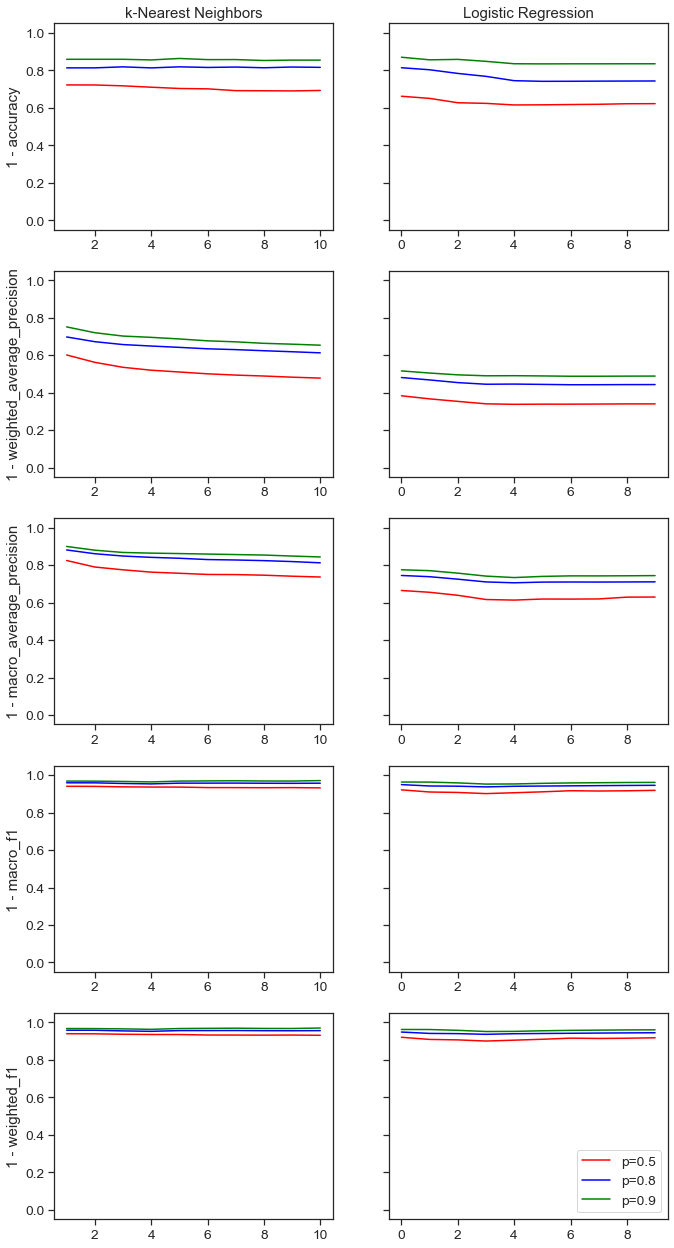

In [40]:
# Plot superquantiles of these loss distributions.
sns.set(font_scale = 1.25)
sns.set_style("ticks")

fig, axes = plt.subplots(len(metrics), len(algos), figsize=(11,22), sharey=True)

colors = ["red", "blue", "green"]

for i, metric_name in enumerate(metric_names):
    axes[i,0].set_ylim(-0.05, 1.05)
    axes[i,0].set_ylabel("1 - %s" % metric_name)
    for j, algo in enumerate(algos):
        out = compute_superqantiles(metric_name, algo, locations)
        for k, p in enumerate([0.5, 0.8, 0.9]):
            axes[i, j].plot(algo["job_ids"], out[p], color=colors[k], label="p=%0.1f" % p)
        
for j, algo in enumerate(algos):
    axes[0,j].set_title(algo["name"])
    
# fig.suptitle("iWildCam Baseline Performance")
axes[len(metrics) - 1, len(algos) - 1].legend(loc="lower right")
plt.savefig("../figs/baseline_perf.pdf", bbox_inches="tight")
plt.show()